<center> <b>Machine Learning - SBU FALL 2024</b></center> 

In [1]:
student_number = ''
Name = ''
Last_Name = ''


# MobileNet V1: A PyTorch Tutorial



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 in PyTorch
- Use transfer learning for better accuracy


![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [2]:
# Importing libraries
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [4]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0, mean=mean)
    new_x = (x - mean) / np.sqrt(variance + epsilon)
    return gamma * new_x + beta


In [5]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


## Load dataset

In [6]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
])

# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(root='.', train=True, download=True)

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(root='.', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
x_train_raw, y_train_label = torch.tensor(train_set.data), torch.tensor(train_set.targets)
x_test_raw, y_test_label = torch.tensor(val_set.data), torch.tensor(val_set.targets)

In [8]:
print(x_train_raw.shape, y_train_label.shape)
print(x_test_raw.shape, y_test_label.shape)

torch.Size([50000, 32, 32, 3]) torch.Size([50000])
torch.Size([10000, 32, 32, 3]) torch.Size([10000])


In [9]:
print(x_train_raw.dtype, y_train_label.dtype)

torch.uint8 torch.int64


### Transformations

In [42]:
# x_train_transformed = transform_train(x_train_raw[0].permute(2, 0, 1).numpy())
# x_test_transformed = transform_test(x_test_raw)

TypeError: Unexpected type <class 'numpy.ndarray'>

### Normalization

In [11]:
x_train = x_train_raw.float()
x_test = x_test_raw.float()

#### Norm values between 0 to 1

In [12]:
x_train[0]

tensor([[[ 59.,  62.,  63.],
         [ 43.,  46.,  45.],
         [ 50.,  48.,  43.],
         ...,
         [158., 132., 108.],
         [152., 125., 102.],
         [148., 124., 103.]],

        [[ 16.,  20.,  20.],
         [  0.,   0.,   0.],
         [ 18.,   8.,   0.],
         ...,
         [123.,  88.,  55.],
         [119.,  83.,  50.],
         [122.,  87.,  57.]],

        [[ 25.,  24.,  21.],
         [ 16.,   7.,   0.],
         [ 49.,  27.,   8.],
         ...,
         [118.,  84.,  50.],
         [120.,  84.,  50.],
         [109.,  73.,  42.]],

        ...,

        [[208., 170.,  96.],
         [201., 153.,  34.],
         [198., 161.,  26.],
         ...,
         [160., 133.,  70.],
         [ 56.,  31.,   7.],
         [ 53.,  34.,  20.]],

        [[180., 139.,  96.],
         [173., 123.,  42.],
         [186., 144.,  30.],
         ...,
         [184., 148.,  94.],
         [ 97.,  62.,  34.],
         [ 83.,  53.,  34.]],

        [[177., 144., 116.],
       

In [13]:
# Normalize the pixel values and one-hot encode the labels
x_train /= 255
x_test /= 255
assert x_train.max() <= 1.0
assert x_test.max() <= 1.0

### One hot encoding

In [14]:
num_classes = len(np.unique(y_train_label))
print(num_classes)

10


In [15]:
# Convert labels to one-hot encoding
def one_hot(y, num_classes) -> torch.Tensor:
    one_hot = torch.zeros(num_classes)
    one_hot[y] = 1
    return one_hot

y_train = torch.stack([one_hot(y, num_classes) for y in y_train_label])
y_test = torch.stack([one_hot(y, num_classes) for y in y_test_label])

In [16]:
print(y_train.shape, y_test.shape)

torch.Size([50000, 10]) torch.Size([10000, 10])


## Plot the CIFAR-10 dataset

### Transformed images

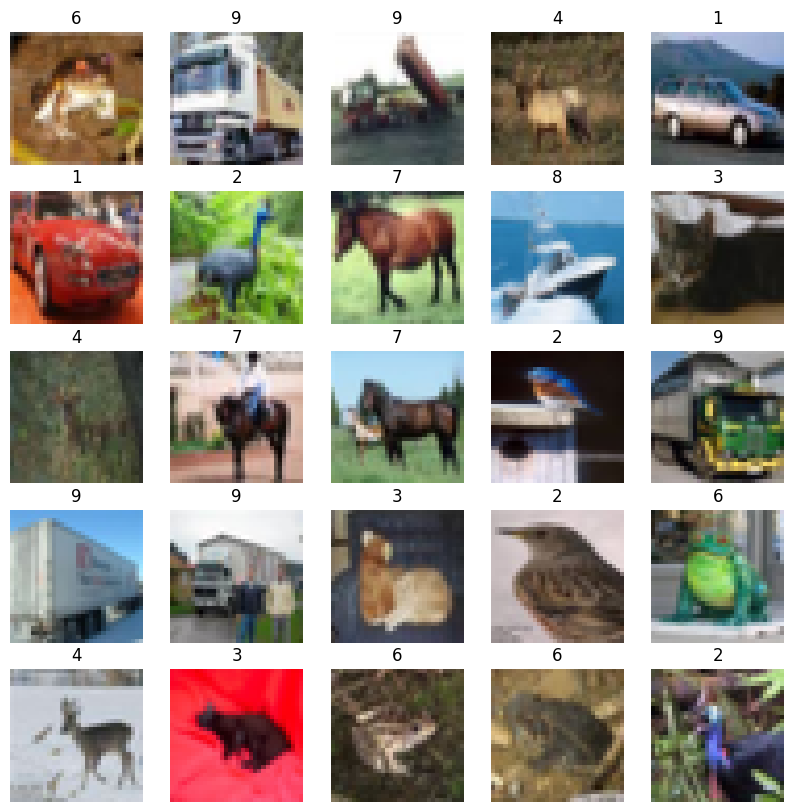

In [17]:
image_for_plot = x_train[:25].numpy()
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_for_plot[i])
    plt.title(y_train_label[i].item())
    plt.axis('off')

### Raw images

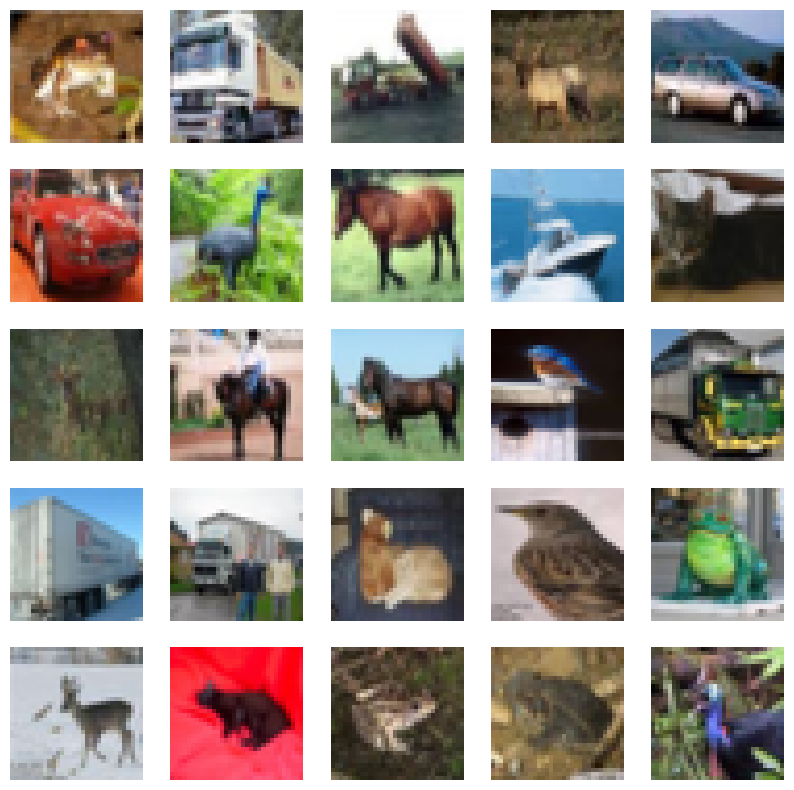

In [18]:
image_for_plot = torch.tensor(train_set.data)[:25].numpy()
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_for_plot[i])
    plt.axis('off')

## Define Model

![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [35]:
class ConvBatchNormal(nn.Module):
    def __init__(self, input, output, kernel_size, stride, padding):
        super().__init__()
        self.stack_modules = nn.Sequential(
            nn.Conv2d(input, output, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(output),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.stack_modules(x)

def conv_dw(input, output, stride):
    # Define a depthwise separable convolution layer
    # Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    # Parameters:
    # input: Number of input channels
    # output: Number of output channels
    # stride: Stride size for the depthwise convolution
    pass

In [20]:
class MyBaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.accuracy_train_history = []
        self.accuracy_test_history = []
        self.loss_train_history = []
        self.loss_test_history = []

    def save(self, path):
        torch.save(self, path)

    @staticmethod
    def load(path) -> nn.Module|None:
        model = None
        if os.path.exists(path):
            print(f'Loading from disc: {path}')
            model = torch.load(path, weights_only=False)
            model.eval()
        else:
            print('Model not found!')
        return model

In [21]:
class MobileNet(MyBaseModel):
    def __init__(self, n_class=1000):
        super().__init__()
        pass

    def forward(self, x):
        pass

### Reshape images

In [22]:
x_train = x_train.permute((0, 3, 1, 2))
x_test = x_test.permute((0, 3, 1, 2))

### Create Mini-batch

In [23]:
batch_size = 100
x_train_batch = x_train.reshape(-1, batch_size, x_train.shape[1], x_train.shape[2], x_train.shape[3])
y_train_batch = y_train.reshape(-1, batch_size, y_train.shape[1])

In [24]:
print(x_train_batch.shape)
print(y_train_batch.shape)

torch.Size([500, 100, 3, 32, 32])
torch.Size([500, 100, 10])


In [48]:
x_train_batch = x_train_batch.to(device)
y_train_batch = y_train_batch.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

### Training loop with early stopping

In [25]:
def accuracy(pred, y):
    correct = (pred.argmax(dim=1) == y.argmax(dim=1)).type(torch.int8).sum().item()
    return correct / y.shape[0] # average

In [26]:
def train(model, x, y, loss_fn, optimizer):
    model.train()

    # Loop over batches
    for i in range(x.shape[0]):
        # Forward pass and loss calculation
        pred = model(x[i])
        loss = loss_fn(pred, y[i])

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [27]:
def validation(model, x, y, loss_fn):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        pred = model(x)
        loss = loss_fn(pred, y).item()
    return pred, loss

In [28]:
def top_level_func_training(model, loss_fn, optimizer, MODEL_PATH, number_epochs=0, patience=10):
    # Initialize Variables for EarlyStopping
    best_loss = float('inf')
    best_model_weights = copy.deepcopy(model.state_dict())

    # Training Loop with Early Stopping:
    for epoch in tqdm(range(number_epochs)):
        # Train
        train(model, x_train_batch, y_train_batch, loss_fn, optimizer)

        # Validation
        val_pred, val_loss = validation(model, x_test, y_test, loss_fn)
        train_pred, train_loss = validation(model, x_train, y_train, loss_fn)

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here
            patience = 10  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                print('Early stopping...')
                break

        # Save accuracy and loss on test
        model.accuracy_test_history.append(accuracy(val_pred, y_test))
        model.loss_test_history.append(val_loss)

        # Save accuracy and loss on train
        model.accuracy_train_history.append(accuracy(train_pred, y_train))
        model.loss_train_history.append(train_loss)


    # Load the best model weights then save on disc
    model.load_state_dict(best_model_weights)
    model.save(MODEL_PATH)

### Plot

In [29]:
def plot(model):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(model.accuracy_train_history)), np.array(model.accuracy_train_history) * 100, label='Train')
    plt.plot(np.arange(len(model.accuracy_test_history)), np.array(model.accuracy_test_history) * 100, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy (batch size=100)')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(model.loss_train_history)), np.array(model.loss_train_history), label='Train')
    plt.plot(np.arange(len(model.loss_test_history)), np.array(model.loss_test_history), label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss (batch size=100)')
    plt.legend()
    plt.grid()
    plt.show()
    print(f'best loss on test dataset = {model.loss_test_history[-1]:.2f}')
    print(f'best accuracy on test dataset = {model.accuracy_test_history[-1] * 100}%')

## Load Model 1

In [30]:
MODEL_PATH = 'model_mobile_net1.pt'
model = MobileNet.load(MODEL_PATH)
if not model:
    model = MobileNet()
model.to(device)

Model not found!


MobileNet()

### Initialize Optimizer and Loss Functions

In [31]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

ValueError: optimizer got an empty parameter list

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


**answer**

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [ ]:
epochs = 10
lr = 1e-3
# TODO:



Get some metrics and plot your losses.

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


**answer**

## 2.Normal CNN

In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [45]:
class NormalCNN(MyBaseModel):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            ConvBatchNormal(3, 32, kernel_size=3, stride=2, padding=1),
            ConvBatchNormal(32, 64, kernel_size=3, stride=1, padding=1),
            ConvBatchNormal(64, 128, kernel_size=3, stride=2, padding=1),
            ConvBatchNormal(128, 128, kernel_size=3, stride=1, padding=1),
            ConvBatchNormal(128, 256, kernel_size=3, stride=2, padding=1),
            ConvBatchNormal(256, 256, kernel_size=3, stride=1, padding=1),
            ConvBatchNormal(256, 512, kernel_size=3, stride=2, padding=1),
            ConvBatchNormal(512, 512, kernel_size=3, stride=1, padding=1),
            ConvBatchNormal(512, 512, kernel_size=3, stride=1, padding=1),
            ConvBatchNormal(512, 512, kernel_size=3, stride=1, padding=1),
            ConvBatchNormal(512, 512, kernel_size=3, stride=1, padding=1),
            ConvBatchNormal(512, 512, kernel_size=3, stride=1, padding=1),
            ConvBatchNormal(512, 1024, kernel_size=3, stride=2, padding=1),
            ConvBatchNormal(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.AvgPool2d(1),
        )
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.stack(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [49]:
model = NormalCNN()
model.to(device)
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
start = time.time()
top_level_func_training(model, loss_fn, optimizer, None, 2)
end = time.time()
print(end - start)

  0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


  0%|          | 0/79 [00:00<?, ?it/s]

Batch_size=128, epochs=2, lr=0.001
Val accuracy = 0.3071
Process validation time: 20.7095 s


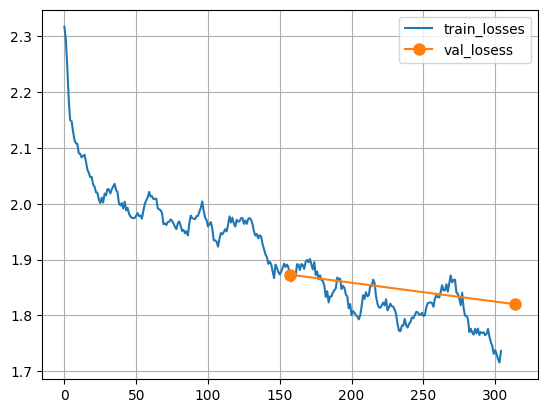

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Compare speed of learning and validating in normal CNN vs MobileNet

**answer**

In [ ]:
# TODO: compare number of parameters in these two models

Total number of normal CNN parameters: 28279338
Total number of MobileNet parameters: 3217226


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

**answer**

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

**answer**

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

**answer**

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

### Speciall thanks to [Amirmahdi Meighani](https://www.linkedin.com/in/amirmm03/) (notebook main author) 

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018